# Assignment 1

### Ferenc Huszar, Nic Lane and Neil Lawrence

### 9th February 2021

Welcome to the first assignment for the Deep Neural Networks module. This assignment will test the principles that we have looked at in the first five lectures. 




## Double Descent

This assignment has six questions for a total of 100 marks.

### Background

In this assignment we are going to start by exploring a recent paper on the 'double descent phenomenon'. 

In [Belkin et al](https://www.pnas.org/content/116/32/15849.short) the authors explore double descent, firstly using *random Fourier features* as a basis function. We quote from their paper below.

> We first consider a popular class of nonlinear parametric models  called random Fourier features (RFF) (13), which can be viewed as a class of 2-layer neural networks with fixed weights in the first layer. The RFF model family $\mathcal{H}_N$ with $N$ (complex-valued) parameters consists of functions
$h : \mathbb{R}^d \rightarrow \mathbb{C}$ of the form
$$
h(x) =\sum_{k=1}^N a_k \phi(x ; v_k ) \quad \text{where} \quad \phi(x ; v_k) := e^{\sqrt{-1}\langle v_k, x\rangle},
$$ 
and the vectors $v_1, \dots , v_N$ are sampled independently from the
standard normal distribution in $\mathbb{R}^d$.

From Belkin et al. pg 2 of paper, section titled **Random Fourier Features**. For more on random Fourier features see [Rahimi and Recht](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf).


**Note** that the notation that Belkin et al use, $\langle v_k, x \rangle$ is just the notation for an inner product between the vector $v_k$ and the vector $x$. We'll use the notation $v_k^\top x$ to denote this below.

Following the papers description, our first task is to create a function for computing the basis. The paper proposes using a basis which is
$$
\exp(i z) = \cos(z) + i \sin(z)
$$
to form the *random Fourier features*. This leads to complex valued weights, $\{a_k\}_{i=1}^N$. So rather than doing that, we set our design matrix up in the following way:
$$
\boldsymbol{\Phi} = \begin{bmatrix} \cos(v_1^\top x_1) & \sin(v_1^\top x_1) & cos(v_2^\top x_1) & \sin(v_2^\top x_1) & \cdots & \cos(v_N^\top x_1) & \sin(v_N^\top x_1) \\
\cos(v_1^\top x_2) & \sin(v_1^\top x_2) & cos(v_2^\top x_2) & \sin(v_2^\top x_2) & \cdots & \cos(v_N^\top x_2) & \sin(v_N^\top x_2) \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
\cos(v_1^\top x_n) & \sin(v_1^\top x_n) & cos(v_2^\top x_n) & \sin(v_2^\top x_n) & \cdots & \cos(v_N^\top x_n) & \sin(v_N^\top x_n)\end{bmatrix}
$$
Giving us a matrix $\boldsymbol{\Phi} \in \mathbb{R}^{n \times 2N}$ where we are following Belkin et al's notation with $n$ number of data points and $N$ number of random Fourier features. Note that because each feature (in our representation) contains a sine and a cosine, the total number of basis functions is $2N$. 

The frequencies of the features, as Belkin et al explain, should be sampled from a normal density. In our notation below we collect these features in a matrix `V`, represented here as a two dimensional `numpy` array.  

If the data is stored in a That leads to the following code for implementing the random Fourier features.

In [1]:
import numpy as np

In [2]:
def random_fourier_basis(X, V):
    arg = X@V
    Phi = np.zeros((X.shape[0], 2*V.shape[1]))
    Phi[:, 0::2] = np.cos(arg) 
    Phi[:, 1::2] = np.sin(arg)
    return Phi

Given our design matrix, $\boldsymbol{\Phi}$ we can compute the output of the functions, which Belkin et al denote $h(x)$ for each of the points using matrix multiplication. 
$$
\mathbf{h} = \boldsymbol{\Phi} \mathbf{a}
$$
where $\mathbf{a} \in \mathbb{R}^N$ is a vector containing the elements $a_k$.


In [3]:
def predict(X_test, a, V):
    Phi_test = random_fourier_basis(X_test, V)
    return Phi_test@a

> Our learning procedure using $\mathcal{H}_N$ is as follows. Given data $(x_1, y_1), \dots , (x_n , y_n )$ from $\mathbb{R}^{d} \times \mathbb{R}$, we find the predictor $h_{n,N} \in \mathcal{H}_N$ via ERM with squared loss. That is, we minimize the empirical risk objective $\frac{1}{n} \sum_{i=1}^n (h(x_i) − y_i)^2$
over all functions $h \in \mathcal{H}_N$. When the minimizer is not unique (as is always the case when $N > n$), we choose the minimizer whose coefficients $(a_1, \dots , a_N )$ have the minimum $\ell_2$ norm. This choice of norm is intended as an approximation to the RKHS norm $\|h\|_{\mathcal{H}_\infty}$, which is generally difficult to compute for arbitrary functions in $\mathcal{H}_N$ . For problems with multiple outputs (e.g., multiclass classification), we use functions with vector-valued outputs and the sum of the squared losses for each output.

We already reviewed empirical risk minimization in the second lecture of week one. Here, Belkin et al are using the *squared loss* even for a classification task. This is probably not something you'd do in practice, but for our analysis below it will serve as it makes gradients easier to compute, and the optimum easy to solve analytically. 

We can implement the average squared error they described as follows. 

In [4]:
def error(X, y, a, V):
    y_pred = predict(X, a, V)
    return np.mean((y_pred - y)**2)

And now we can implement the fixed point update equation we reviewed in [Lecture 2 of Week 1](https://mlatcl.github.io/deepnn/lectures/01-02-generalisation-and-neural-networks.html) for fitting the model.

In [5]:
def fit(X_train, y_train, N, lambd=0.01):
    d = X_train.shape[1]
    V = np.random.normal(0.0, 1, size=(d, N))
    Phi_train = random_fourier_basis(X_train, V)
    if Phi_train.shape[1]>X_train.shape[0]:
        # N > n, use L2 regularizer
        a = np.linalg.solve(Phi_train.T@Phi_train + lambd*np.eye(N*2), Phi_train.T@y_train)
    else:
        a = np.linalg.solve(Phi_train.T@Phi_train, Phi_train.T@y_train)
    return a, V

Here we have included `lambd` to represent a regularisation parameter, so that we can minimize the $\ell_2$ norm as Belkin et al suggest when the number of parameters in the model (which is $2N$ for this random Fourier basis) is greater than the number of data, $n$. This is called [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization).

### Loading a Data Set

For their paper, Belkin et al use the MNIST digits data set. To make things run a little quicker for us, we'll use a digits data set from scikit learn. 

In [6]:
import sklearn
from sklearn import datasets

digits = datasets.load_digits()

The original data has 10 digits. We'll modify the task form classifyign individual digits to separating curvy digits from those with angles. Our task will be to separate `0`, `3`, `6`, `8`, `9` from `1`, `2`, `4`, `5`, `7`. This leads to an approximate balance between positive and negative examples.

In [7]:
X = digits['data']
y = ((digits['target'] == 0)
     | (digits['target'] == 3)
     | (digits['target'] == 6)
     | (digits['target'] == 8)
     | (digits['target'] == 9))

We will normalise the input data. Normalization is often a key part of getting machine learning algorithms working well. In many cases, you would normalize the columns of your data independently. But here, because it's an image, my instinct is to apply a single scaling. Because the pixels live naturally on the same scale originally. 

In [8]:
X /= X.std()
X /= np.sqrt(64)

I've subsequently also scaled by the square root of the dimensionality. This ensures that on average, the length of the vector $x$ is 1/64, or in other words, $1/d$ where $d$ is the dimensionality of the input image (which is $8\times 8$).

Similarly, it's quite common to use labels of $-1$ or $1$ for targets when using a squared error. This works well because it's symmetric about zero. But an encoding of $0$ vs $1$ would also likely work. 

In [9]:
y = y*2 - 1

We can use scikit learn's built in facility for forming a training and test set from the model. 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=False)

And now we can use our code to fit our model. 

In [11]:
a, V = fit(X_train, y_train, 200)

And check the error. 

In [12]:
e = error(X_test, y_test, a, V)
print('Error: {}'.format(e))

Error: 0.23825405405916628


### Question 1

Fit models using different values for $N$ between 1 and 2000. 

Produce a plot that has an $x$-axis given by the number of parameters in the model (remember that's $2N$) divided by the number of *training* data. On the $y$-axis plot the loss computed on the *test* data. This serves as an estimate of the true risk.

Choose appropriate intervals for plotting so that the full form of the curve is seen. Beware that the fit will be slow as $N\rightarrow 2000$. 

You can use `matplotlib` or your preferred plotting library to create the plot.

Describe what you see in the plot with reference to both *classical* generalisation theory and the generalisation performance of modern neural network models.

*15 marks*

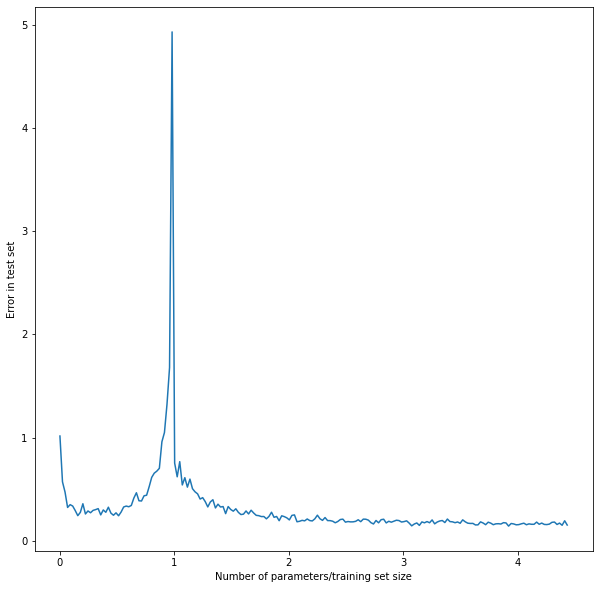

In [13]:
import matplotlib.pyplot as plt

xs, ys = [], []
n_train = X_train.shape[0]
for N in range(1, 2001, 10):
    xs.append(2 * N / n_train)
    a, V = fit(X_train, y_train, N)
    e = error(X_test, y_test, a, V) 
    ys.append(e)

plt.xlabel("Number of parameters/training set size")
plt.ylabel("Error in test set")
plt.gcf().set_size_inches(10, 10)
plt.plot(xs, ys)

#### Answer 1 text

The part of the curve up to the peak can be explained by classical generalisation theory - as we increase the number of parameters, we're increasing the complexity of our model, which can lead to better performance and generalisation at first, but is likely to cause overfitting as we keep increasing. When the number of parameters = the training set size, we can get an exact fit and our training error will be zero, and classical generalisation thoery says this is unlikely to generalise well, hence the peak.

The latter part of the curve relates well to the generalisation performance of modern neural networks - that heavily overparameterised systems can indeed generalise well. This is called the "Double Descent" phenomenon



## Gradient descent in pytorch

 Having seen the model above written in `numpy` we are now going to explore the same model in `pytorch`. First we rewrite our basis functions.

In [14]:
import torch

In [15]:
def random_fourier_basis(X, V):
    arg = X@V
    Phi = torch.zeros((X.shape[0], 2*V.shape[1]))
    Phi[:, 0::2] = torch.cos(arg) 
    Phi[:, 1::2] = torch.sin(arg)
    return Phi

In [16]:
def predict(X_test, a, V):
    Phi_test = random_fourier_basis(X_test, V)
    return Phi_test@a

In [17]:
def error(X, y, a, V):
    y_pred = predict(X, a, V)
    return torch.mean((y_pred - y)**2)


In [18]:
# For completeness we also include the function for 'direct fit' in pytorch. You 
# don't need it for the answers below but you can use it to check convergence
# if you like.

def fit(X_train, y_train, N, lambd=0.01):
    d = X_train.shape[1]
    V = torch.normal(0.0, 1, size=(d, N))
    Phi_train = fourier_basis(X_train, V)
    if Phi_train.shape[1]>X_train.shape[0]:
        # N > n, use L2 regularizer
        a, LU = torch.solve(Phi_train.T@y_train, Phi_train.T@Phi_train + lambd*eye(N*2))
    else:
        a, LU = torch.solve(Phi_train.T@y_train, Phi_train.T@Phi_train)
    return a, V

Because we will fit these models with gradient descent now, we have to randomly initialize the parameters.

In [19]:
N = 2000
a = torch.normal(0, 0.001, size=(2*N, 1))
V = torch.normal(0.0, 1, size=(X.shape[1], N))

We also have to tell `torch` that `a` is a variable that we would like to later calculate gradients with respect to, using the `.requires_grad` attribute. The result of this is that wherever we use the variable `a` in subsequent Maths operations, a computational graph with all those operations is going to be built in the background. This computational graph is what allows the `autograd` module of `torch` to later calculate gradients using reverse-mode automatic differentiation, a.k.a. backpropagation.

As in this example we assume `V` to be fixed to randomly selected values, and not learned, so we don't need to do the same for that variable.

In [20]:
a.requires_grad=True

*We* need to convert our training and test data from `numpy` arrays into `pytorch` tensors. Note that by default pytoch works with single precision, so we also convert these data arrays (which are `double` in `numpy`) to `float`.

In [21]:
Xt_train = torch.from_numpy(X_train).float()
Xt_test = torch.from_numpy(X_test).float()
yt_train = torch.from_numpy(y_train[:, np.newaxis]).float()
yt_test = torch.from_numpy(y_test[:, np.newaxis]).float()

The magic of automatic differentiation allows us to compute the gradients in `pytorch` by requesting `.backward()`. This function can be called on any `pytorch` tensor that has a computational graph attached. Backpropagation will walk bacjwards on this computational graph and save the relevant gradients in the `.grad` attribute of each `Tensor` whose `requires_grad` attribute is set to `True.`

In [22]:
error(Xt_train, yt_train, a, V).backward()

And now we can simply look at the gradient from pytorch.

In [23]:
a.grad

tensor([[-0.0122],
        [-0.0421],
        [-0.0635],
        ...,
        [-0.0288],
        [ 0.0990],
        [-0.1948]])

### Question 2

Analytically derive the gradient for the objective function with respect to parameters $\mathbf{a}$. Give your answer in the box below.

Then implement the answer in code and compare the gradient to the values given by `autograd` in `pytorch` with a scatter plot.

*10 marks*

#### Answer 2

Please add your answer by completing the equation below.

The gradient of the loss with respect to $\mathbf{a}$ is:
$$
\frac{\text{d}}{\text{d} \mathbf{a}} \frac{1}{n} (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y})^\top (\boldsymbol{\Phi} \mathbf{a} − \mathbf{y}) = \frac{2}{n}(\mathbf{\Phi}^T\mathbf{\Phi}\mathbf{a} - \mathbf{\Phi}^T\mathbf{y})
$$

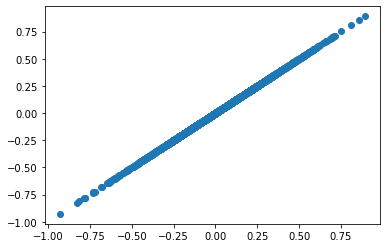

In [24]:
## Place your code for your answer to question 2 in this box.
n = Xt_train.shape[0]
Phi = random_fourier_basis(Xt_train, V)
PhiT = torch.transpose(Phi, 0, 1)
grad = (2/n) * (PhiT @ Phi @ a - PhiT @ yt_train)
plt.scatter(grad.detach().numpy(), a.grad.numpy())

### A simple SGD training loop

Optimisaton of neural networks is typically done by some variant of gradient descent. `pytorch` provides some convenient omptimizaton routines, like `torch.optim.SGD` that we can use to fit the stochastic gradient descent algorithm. 

We include an example of a simple stochastic gradient descent training loop below.

In [25]:
from torch.utils.data import TensorDataset, DataLoader

def sgd_fit(
    X_train, y_train,
    N, a_std = 0.001,
    lr=0.001, epochs=100, batchsize=90):
    ''' Fits a generalised linear model with N random fourier features
    to data using stochastic gradient descent.

    Parameters
    ----------
    X_train, y_train : torch.Tensor
    Training input and output tensors
    N : int
    Number of random Fourier features to use
    a_std : float
    Standard deviation of parameters a at initialization
    lr : float
    Learning rate
    epochs : int
    Number of training epochs
    batchsize : int
    Number of datapoints in each minibatch

    Returns
    -------
    a, V
    torch.Tensors contatining parameters of the trained model
    '''
    dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
    )
    a = torch.normal(0, a_std, size=(2*N, 1))
    a.requires_grad=True
    V = torch.normal(0.0, 1, size=(X.shape[1], N))
    optimizer = torch.optim.SGD([a], lr=lr)
    for t in range(epochs):
        for X_minibatch, y_minibatch in dataloader:
            optimizer.zero_grad()
            error(X_minibatch, y_minibatch, a, V).backward()
            optimizer.step()
    return a, V

Note: In practice, one would not write a training loop from scratch like this. There are well-tested libraries with extensive functionality like `ignite` in pytorch and `keras` in TensorFlow. We included this simple code so as to illustrate what is going on in a SGD training loop.

### Question 3

Now we have used `pytorch` to compute the gradients, we'll optimize with stochastic gradient descent. 

Firstly, you'll look at the convergence of stochastic gradient descent for four different sizes of model, $N=5$, $N=100$, $N=400$ and $N=1000$.

Modify the `sgd_fit` code to monitor convergence of both the test error and the training error as training progresses.

Produce plots of the changing training and test error as the iterations procede for each model size $N$ above.

For each model size ($N$) vary the the learning rate, number of iterations, batchsize, to improve the rate of convergence.

You may want to use `torch.manual_seed` to set the random seed. Try different random seeds. What do you find?

*15 marks*



In [26]:
## You can modify the function below to create your answers

def sgd_fit_plot(
    X_train, y_train, X_test, y_test,
    N, a_std = 0.001,
    lr=0.001, epochs=100, batchsize=30):
    dataloader = DataLoader(
      TensorDataset(X_train, y_train),
      batch_size=batchsize,
      shuffle=True
    )
    a = torch.normal(0, a_std, size=(2*N, 1))
    a.requires_grad=True
    V = torch.normal(0.0, 1, size=(X.shape[1], N))
    optimizer = torch.optim.SGD([a], lr=lr)
    train_error = []
    test_error = []
    for t in range(epochs):
        for X_minibatch, y_minibatch in dataloader:
            optimizer.zero_grad()
            error(X_minibatch, y_minibatch, a, V).backward()
            optimizer.step()
            
        train_error.append(error(X_train, y_train, a, V))
        test_error.append(error(X_test, y_test, a, V))
        
    return a, V, train_error, test_error

In [27]:
def plot(N):
    """
    Tries different combinations of learning rate, batch size and number of epochs
    and chooses the one with the lowest final test error to plot
    """
    
    bestCombo = None
    minTrainError = None
    for lr in [0.001, 0.002, 0.003]:
        for batchsize in [20, 30, 40]:
            for epochs in [50, 100, 150]:
                _,_, train_error, test_error = sgd_fit_plot(Xt_train, yt_train, Xt_test, yt_test, N, lr=lr, epochs=epochs, batchsize=batchsize)
                if minTrainError is None or test_error[-1] < minTrainError:
                    minTrainError = test_error[-1]
                    bestCombo = (lr, batchsize, epochs, train_error, test_error)
                
    
    (lr, batchsize, epochs, train_error, test_error) = bestCombo
    xs = 1 + np.arange(len(train_error))
    plt.plot(xs, train_error, label="Train Error")
    plt.plot(xs, test_error, label="Test Error")
    plt.legend()
    plt.title(f"Lr:{lr}, batchsize: {batchsize}, epochs: {epochs}")

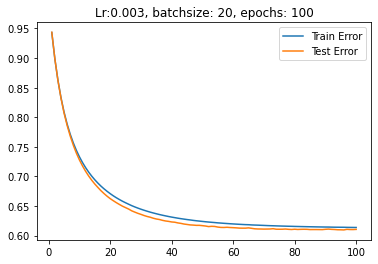

In [28]:
## Place your code for your answer to question 3 for N=5 in this box.
torch.manual_seed(0)
plot(5)

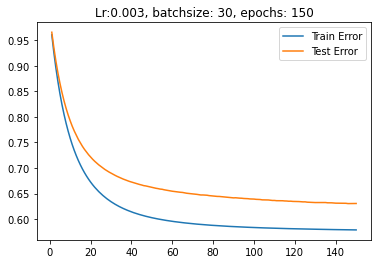

In [29]:
torch.manual_seed(1)
plot(5)

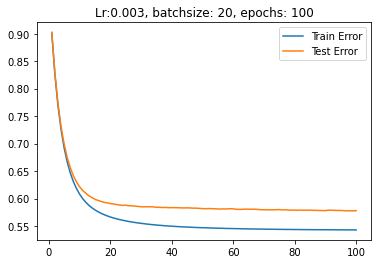

In [30]:
torch.manual_seed(2)
plot(5)

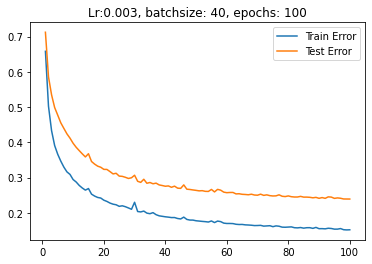

In [31]:
## Place your code for your answer to question 3 for N=100 in this box.
torch.manual_seed(0)
plot(100)

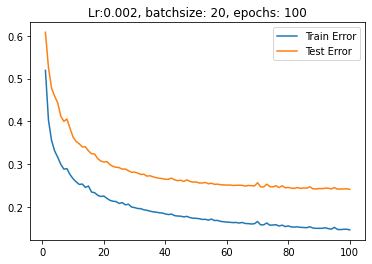

In [32]:
torch.manual_seed(1)
plot(100)

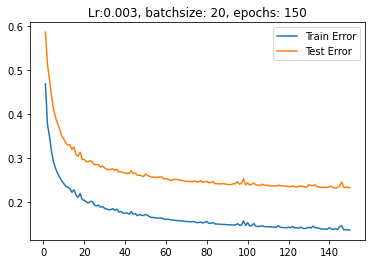

In [33]:
torch.manual_seed(2)
plot(100)

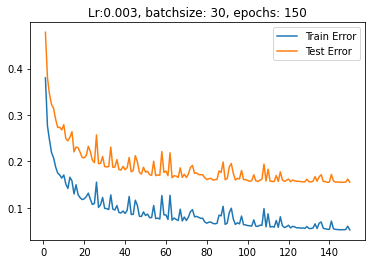

In [34]:
## Place your code for your answer to question 3 for N=400 in this box.
torch.manual_seed(0)
plot(400)

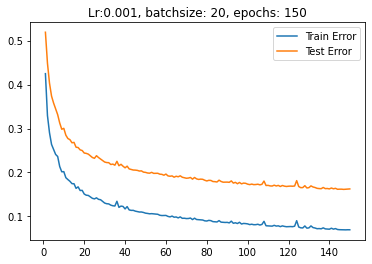

In [35]:
torch.manual_seed(1)
plot(400)

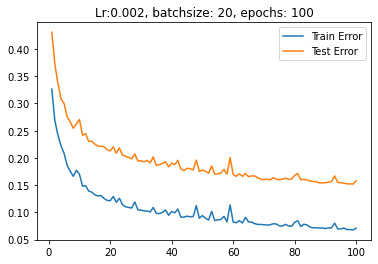

In [36]:
torch.manual_seed(2)
plot(400)

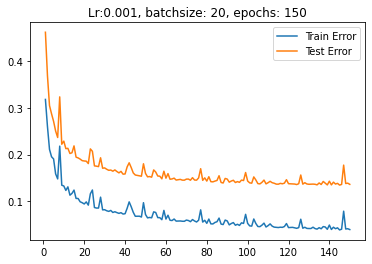

In [37]:
## Place your code for your answer to question 3 for N=1000 in this box.
torch.manual_seed(0)
plot(1000)

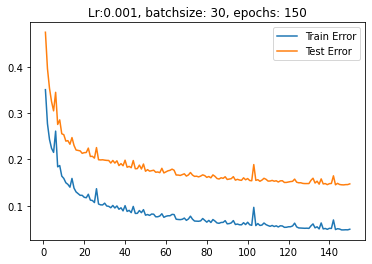

In [38]:
torch.manual_seed(1)
plot(1000)

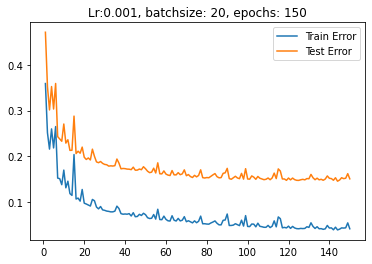

In [39]:
torch.manual_seed(2)
plot(1000)

#### Answer 3

The main observation is that the higher the value of N used, the less "smooth" and more "jumpy" the convergence. In terms of the 3 hyperparameters (learning rate, batch size and number of epochs):

- I didn't see any "obvious" learning rates that were better than the other out of the three tried. However, I observed that using too high a learning rate (which I tried seperately, not shown in the plots) leads to instability - the "a" vector becomes filles with "NaNs". 
- I also didn't see any batch sizes that performed better than any of the others
- Out of the 3 values I tried for the epochs, I foind 150 was the best. In general, the loss function didn't ever start increasing, hence the more epochs, the better (usually)

Trying different random seeds seemed to affect the rate of convergence more for smaller N. For larger N, I found that it affects the "smoothness" of the loss function, which is probably due to the initialisation of the "a" vector

### Question 4

Use what you have learned about learning rates and number of training iterations to recreate the plot of test error against $2N/n$  but using stochastic gradient descent to plot the new model. 

Justify your choice of learning rate and model dimensionality.

Compare this plot with the direct fit you did in numpy above. How do they differ?

*20 marks*

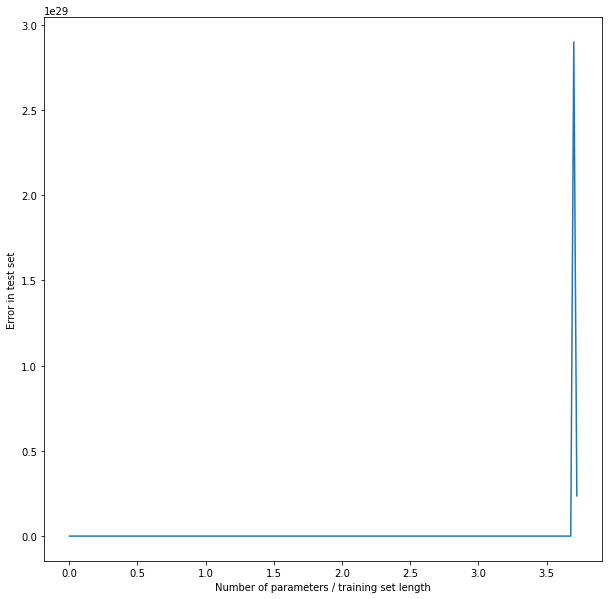

In [40]:
## Place your code for your answer to question 4 in this box.
xs, ys = [], []
n_train = Xt_train.shape[0]

for N in range(1, 2001, 10):
    xs.append(2 * N / n_train)
    a, V = sgd_fit(Xt_train, yt_train, N, lr=0.001)
    e = error(Xt_test, yt_test, a, V) 
    ys.append(e.item()) #Use e.item() to get the number instead of the tensor 

plt.xlabel("Number of parameters / training set length")
plt.ylabel("Error in test set")
plt.gcf().set_size_inches(10, 10)
plt.plot(xs, ys)

#### Answer 4

I decided to stick with a learning rate of 0.001 since it leads to stable values and also performed the best at high values of N. I also used the same model dimensionality values (i.e. same N values) that I used in quesiton 1 so a valid comparison can be made. The main differences I see to the direct numpy fit are that the peak is much further to the right, and also the error value at the peak is much higher in this case (being about $3 * 10^{29}$ as opposed to about 8 before), which is probably more due to **exploding gradients** rather than overfitting



## Sawtooth network

This part of the assignment looks at the *sawtooth* network Ferenc showed in the third lecture to demonstrate that deep ReLU networks can represent exponentially complex piecewise linear functions. The function is defined by the following recursion:

\begin{align}
f_l(x) &= 2\cdot \vert f_{l-1}(x)\vert - 2\\
f_0(x) &= x
\end{align}

This function can be implemented as a deep, narrow neural network with just two ReLU units at each layer. Below, I provide a simple `pytorch` implementation. The network has three different layers in it: the input layer, the middle layers, which are repeated, and the output layer. ReLU nonlinearities are sandwiched between them.


In [41]:
from torch.nn import Identity, Sequential, Linear, ReLU

def sawtooth_input_layer():
    '''Input layer of a Sawtooth network. A Linear layer with fixed weights.'''
    layer = Linear(1, 2, bias=False)
    with torch.no_grad():
        layer.weight.data = torch.Tensor([[1], [-1]])
    return layer 

def sawtooth_middle_layer():
    '''Middle layer of a Sawtooth network. A Linear layer with fixed weights.'''
    layer = Linear(2, 2)
    with torch.no_grad():
        layer.weight.data = torch.Tensor([[2, 2], [-2, -2]])
        layer.bias.data = torch.Tensor([-2, 2])
    return layer

def sawtooth_output_layer():
    '''Output layer of a Sawtooth network. A Linear layer with fixed weights.'''
    layer = Linear(2, 1)
    with torch.no_grad():
        layer.weight.data = torch.Tensor([[2, 2]])
        layer.bias.data = torch.Tensor([-2])

    return layer

def get_sawtooth_network(num_hidden_layers = 5, middle_layer = sawtooth_middle_layer):
    '''Returns a nn.Sequential model with ReLU activations and weights fixed to
    implement the sawtooth function.

    Parameters
    ----------
    num_hidden_layers : int
    Specifies the number of hidden layers. When 0, the Identity is returned.
    middle_layer: function
    Function to use to construct the layers in the middle. Default is to use
    `sawtooth_middle_layer`.
    '''
    
    blocks = []
    if num_hidden_layers < 0:
        raise ValueError('Number of hidden layers must be non-negative')  
    elif num_hidden_layers == 0:
        blocks = [Identity]
    else:
        for l in range(num_hidden_layers):
            if l==0:
                blocks.append(sawtooth_input_layer())
            else:
                blocks.append(middle_layer())
            blocks.append(ReLU())
        blocks.append(sawtooth_output_layer())
        
    return Sequential(*blocks)
    

In pytorch, you can use models the same way as if they were python functions. Below I plot a 6-layer network's output. (note that we have to call `.detach` on the output of the model which detaches the data from the computational graph that was built, which would be used for automatic differentiation).

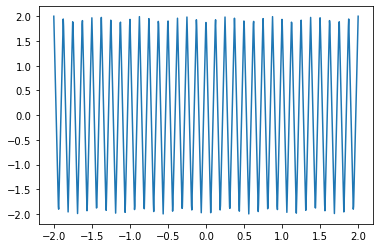

In [42]:
x = torch.linspace(-2,2,1000)[:, None]

model = get_sawtooth_network(6)

plt.plot(x, model(x).detach());

The sawtooth network was deliberately constructed to show that exponentially complex networks can be represented by even very simple deep network architectures like this. But are they typical? How easy is it to break this exponential complexity property of the sawtooth networks? The assignment question below explores this a bit.

### Question 5

I implemented `get_sawtooth_network` so that it is possible to pass a custom functions for constructing the *middle* layers of the network. Create two new versions of this middle layer constructor in the code blocks below:

1. `noisy_sawtooth_middle_layer` should initialize the weights with a bit of random perturbation around the original fixed weights of the sawtooth network. The magnitude of the perturbation is controlled by an argument `noise_level`
2. `random_init_middle_layer` should initialize the weights completely randomly.

Create new models using these randomized layers and plot the model's output like above. I have included code blocks for plotting for convenience. Describe what you find. Is the number of linear segments still exponential?

Finally try reinitializing the whole model weights using standard initialization scheme. *Tip:* Use the `reset_parameters` function on each `Linear` layer in the model.

Please add a summmary to the text cell below.

*20 marks*

In [43]:
# Modify the function below so it returns a layer with randomly perturbed
# weights and biases

def noisy_sawtooth_middle_layer(noise_level = 0.1):
    '''A noisy middle layer of a Sawtooth network. A 2x2 linear layer whose weights
    are randomly perturbed around the fixed weights of the sawtooth network.

    Parameters
    ----------
    noise_level : float
    Controls the amount of noise added.
    '''
    layer = Linear(2, 2)
    with torch.no_grad():
        weights = np.array([[2, 2], [-2, -2]]) + np.random.normal(loc=0, scale=noise_level, size=(2, 2))
        biases = np.array([-2, 2]) + np.random.normal(loc=0, scale=noise_level, size=2)
        layer.weight.data = torch.Tensor(weights)
        layer.bias.data = torch.Tensor(biases)
    return layer

In [44]:
# Modify the function below so it returns a layer with randomly initialized
# weights and biases. 

def random_init_middle_layer(noise_level = 0.1):
    '''A randomly initialized 2x2 linear layer.'''
    layer = Linear(2, 2)
    with torch.no_grad():
        weights = np.random.uniform(low=-noise_level, high=noise_level, size=(2, 2))
        biases = np.random.uniform(low=-noise_level, high=noise_level, size=2)
        layer.weight.data = torch.Tensor(weights)
        layer.bias.data = torch.Tensor(biases)
    return layer

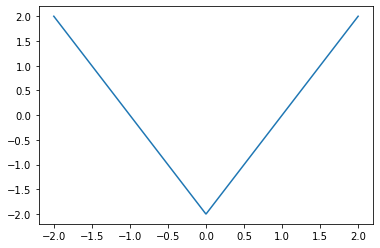

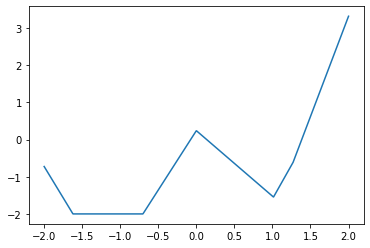

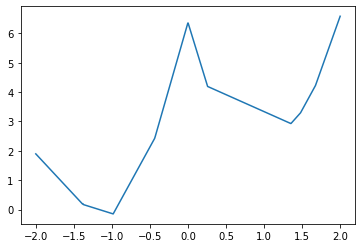

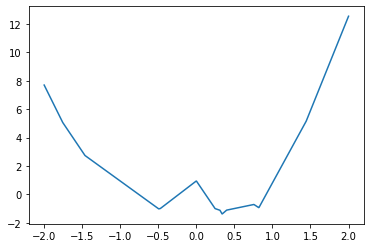

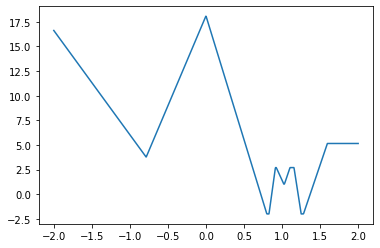

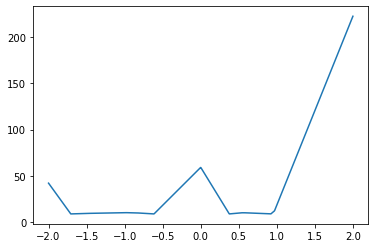

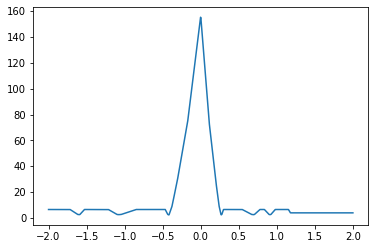

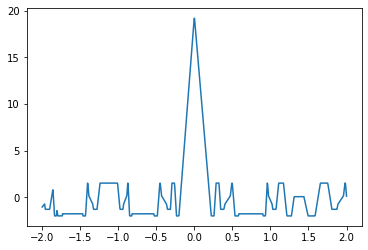

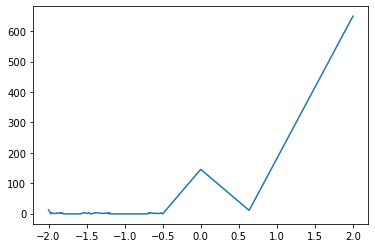

In [45]:
# Noisy Sawtooth
for num_layers in range(1, 10):
    
    model = get_sawtooth_network(
        num_hidden_layers = num_layers,
        middle_layer = lambda : noisy_sawtooth_middle_layer(noise_level=0.7)
    )
    
    plt.plot(x, model(x).detach())
    plt.show()

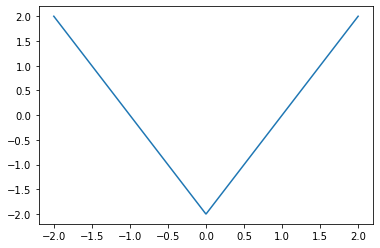

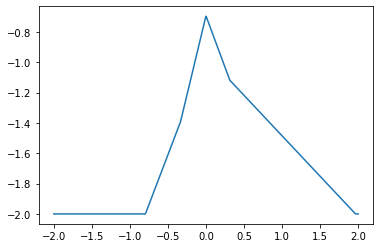

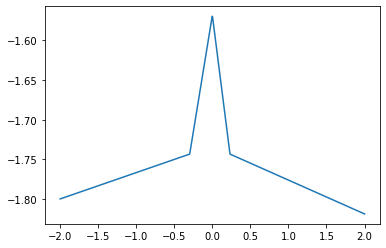

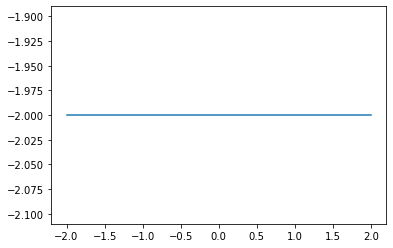

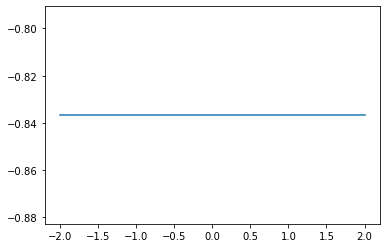

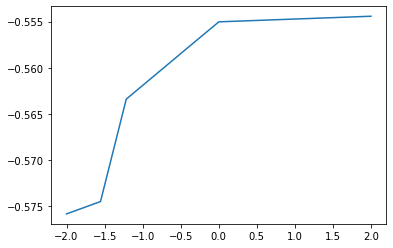

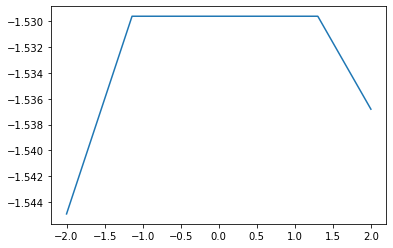

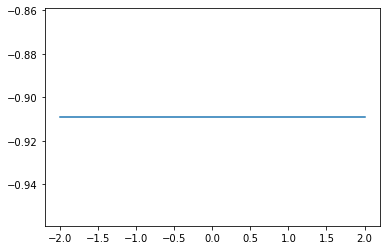

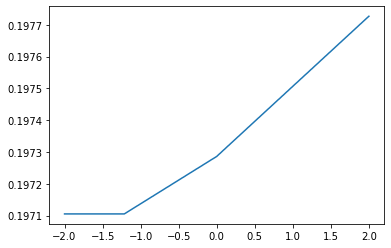

In [46]:
#Random initialisation
for num_layers in range(1, 10):
    
    model = get_sawtooth_network(
        num_hidden_layers = num_layers,
        middle_layer = lambda : random_init_middle_layer(noise_level=0.7)
    )

    plt.plot(x, model(x).detach())
    plt.show()

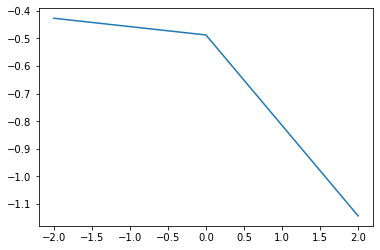

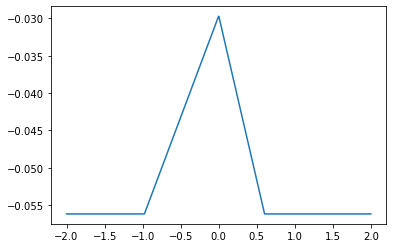

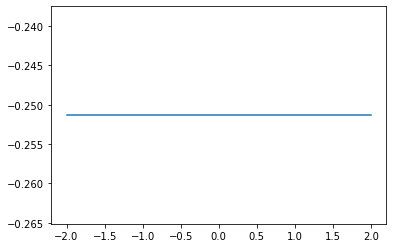

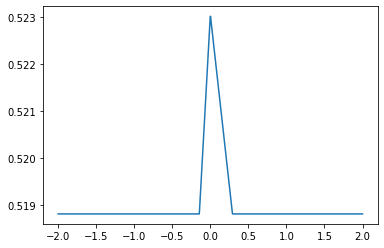

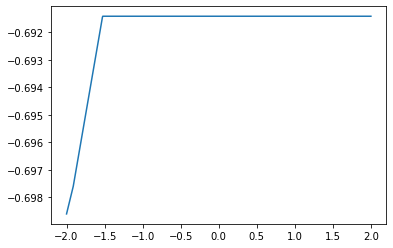

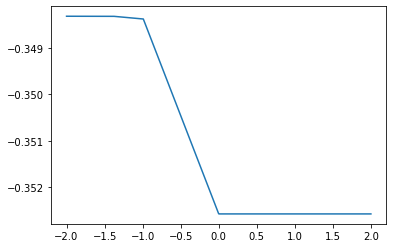

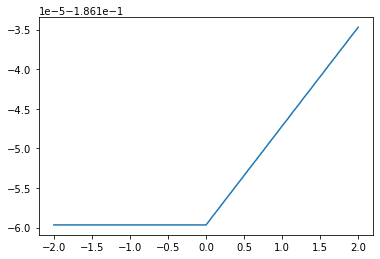

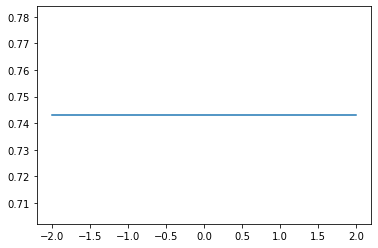

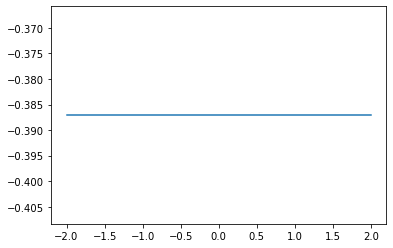

In [47]:
#Standard initialisation
for num_layers in range(1, 10):
    
    model = get_sawtooth_network(num_layers)
    for layer in model:
        if isinstance(layer, Linear):
            layer.reset_parameters()
            

    plt.plot(x, model(x).detach())
    plt.show()

#### Answer 5 text

- Using `noisy_sawtooth_middle_layer()`, I found that although the shape of the curve was very different to the original sawtooth network, the complexity of the network is still exponential in the depth
- Using `random_init_middle_layer()`, I found that the complexity was not exponential. In fact, for depths higher than 5 I mostly just saw flat curves
- Using the pytorch initialisation scheme via `reset_parameters()`, I also did not see exponential complexity, and actually saw similar results to the random initialisation scheme

## Data Movement

During the hardware lecture last Thursday, Nic discussed the importance of data movement and overhead (such as increased latency) that can occur when data is forced to 'spill over' into slow parts of the memory/storage hierarchy during inference or training. 

To assist with this challenge a range of model architectures have been developed that have small memory footprints. One very popular architecture of this variety is  [MobileNetv2](https://arxiv.org/abs/1801.04381). It was designed to run on smartphones and similar devices through an architecture that reduces memory and compute requirements, while still maintaining accuracy for common vision tasks.





### Question 6

__Part 1:__ The working set of each layer in the model (defined during the Thursday lecture) is one way of defining the memory requirement of a neural network. Estimate the working set of each layer of MobileNetv2 and provide it as a table assuming only inference is performed. In the MobileNetv2 paper linked above, you will find Table 2 provides a detailed description of each layer of the model, please base your answer on this specification. You can compute this by hand, or you could specify the architecture in pytorch and use a function like [modelsummary](https://pypi.org/project/pytorch-model-summary/) to help you. Include a brief explaination as to how you calculated the values for your table. *Please remember the working set memory of each layer will be larger than just the weight parameters alone.*

__Part 2:__ Assume that you perform inference using MobileNetv2 on a low-end mobile processor that has 128Kb of on-chip memory available for the model to use. Your input is 56x56 in size, how many times when performing one inference will you need to use off-chip memory?  

*If you find it necessary to make certain assumptions when providing your answers, please briefly state them as part of your answer.*

*20 marks*

#### Answer 6 Part 1


The MobileNetv2 model is already available via the torchvision package, so I am using that for my answer. The documentation for it at https://pytorch.org/vision/0.8/models.html even says the implementation is based on the same paper linked above.

In [48]:
import torch
from torchvision.models import mobilenet_v2
from pytorch_model_summary import summary

model = mobilenet_v2()

#Print out the model summary when performing inference on a 224*224*3 image
print(summary(model, torch.zeros((1, 3, 224, 224)), show_input=True))

-----------------------------------------------------------------------------
          Layer (type)           Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 3, 224, 224]             864             864
         BatchNorm2d-2     [1, 32, 112, 112]              64              64
               ReLU6-3     [1, 32, 112, 112]               0               0
    InvertedResidual-4     [1, 32, 112, 112]             896             896
    InvertedResidual-5     [1, 16, 112, 112]           5,136           5,136
    InvertedResidual-6       [1, 24, 56, 56]           8,832           8,832
    InvertedResidual-7       [1, 24, 56, 56]          10,000          10,000
    InvertedResidual-8       [1, 32, 28, 28]          14,848          14,848
    InvertedResidual-9       [1, 32, 28, 28]          14,848          14,848
   InvertedResidual-10       [1, 32, 28, 28]          21,056          21,056
   InvertedResidual-11       [1, 64, 14, 14]          54,272          54,27

Assuming the working set size of each layer is the number of inputs + the number of parameters + the number of outputs, we get the following table:

| Layer               | Number of Inputs | Number of parameters | Number of outputs | Working set size |
|---------------------|------------------|----------------------|-------------------|------------------|
| Conv2d-1            | 150528           | 864                  | 401408            | 552800           |
| BatchNorm2d-2       | 401408           | 64                   | 401408            | 802880           |
| ReLU6               | 401408           | 0                    | 401408            | 802816           |
| InvertedResidual-4  | 401408           | 896                  | 200704            | 603008           |
| InvertedResidual-5  | 200704           | 5136                 | 75264             | 281104           |
| InvertedResidual-6  | 75264            | 8832                 | 75264             | 159360           |
| InvertedResidual-7  | 75264            | 10000                | 25088             | 110352           |
| InvertedResidual-8  | 25088            | 14848                | 25088             | 65024            |
| InvertedResidual-9  | 25088            | 14848                | 25088             | 65024            |
| InvertedResidual-10 | 25088            | 21056                | 12544             | 58688            |
| InvertedResidual-11 | 12544            | 54272                | 12544             | 79360            |
| InvertedResidual-12 | 12544            | 54272                | 12544             | 79360            |
| InvertedResidual-13 | 12544            | 54272                | 12544             | 79360            |
| InvertedResidual-14 | 12544            | 66624                | 18816             | 97984            |
| InvertedResidual-15 | 18816            | 118272               | 18816             | 155904           |
| InvertedResidual-16 | 18816            | 118272               | 18816             | 155904           |
| InvertedResidual-17 | 18816            | 115264               | 7840              | 141920           |
| InvertedResidual-18 | 7840             | 320000               | 7840              | 335680           |
| InvertedResidual-19 | 7840             | 320000               | 7840              | 335680           |
| InvertedResidual-20 | 7840             | 473920               | 15680             | 497440           |
| Conv2d-21           | 15680            | 409600               | 62720             | 488000           |
| BatchNorm2d-22      | 62720            | 2560                 | 62720             | 128000           |
| ReLU6-23            | 62720            | 0                    | 1280              | 64000            |
| Dropout-24          | 1280             | 0                    | 1280              | 2560             |
| Linear-25           | 1280             | 1281000              | 1000              | 1283280          |


#### Answer 6 Part 2

First we will print out what the model layers look like for a 56 * 56 * 3 image:

In [49]:
print(summary(model, torch.zeros((1, 3, 56, 56)), show_input=True))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 3, 56, 56]             864             864
         BatchNorm2d-2     [1, 32, 28, 28]              64              64
               ReLU6-3     [1, 32, 28, 28]               0               0
    InvertedResidual-4     [1, 32, 28, 28]             896             896
    InvertedResidual-5     [1, 16, 28, 28]           5,136           5,136
    InvertedResidual-6     [1, 24, 14, 14]           8,832           8,832
    InvertedResidual-7     [1, 24, 14, 14]          10,000          10,000
    InvertedResidual-8       [1, 32, 7, 7]          14,848          14,848
    InvertedResidual-9       [1, 32, 7, 7]          14,848          14,848
   InvertedResidual-10       [1, 32, 7, 7]          21,056          21,056
   InvertedResidual-11       [1, 64, 4, 4]          54,272          54,272
   InvertedResidual-12  

Assumptions:

- The number of off-chip memory accesses of each layer will be the working set size of that layer in bytes / 128 Kb, using **integer division**
- Parameters, inputs and outputs are stores as **32 bit floats**. So the working set size of each layer in bytes is four times the working set size in terms of pure numbers
- Kb stands for kilobytes, and there are **1000** bytes in a kilobyte. So the number of off-chip memory accesses in a layer is the working set size in bytes / 128000, using integer division
- The number of accesses to off-chip memory needed can be calculated by summing the number of off-chip memory accesses for each layer

We can then derive the following table:

| Layer               | Number of Inputs | Number of parameters | Number of outputs | Working set size | Working set size in bytes | Off-chip memory accesses |
|---------------------|------------------|----------------------|-------------------|------------------|---------------------------|--------------------------|
| Conv2d-1            | 9408             | 864                  | 25088             | 35360            | 141440                    | 1                        |
| BatchNorm2d-2       | 25088            | 64                   | 25088             | 50240            | 200960                    | 1                        |
| ReLU6               | 25088            | 0                    | 25088             | 50176            | 200704                    | 1                        |
| InvertedResidual-4  | 25088            | 896                  | 12544             | 38528            | 154112                    | 1                        |
| InvertedResidual-5  | 12544            | 5136                 | 4704              | 22384            | 89536                     | 0                        |
| InvertedResidual-6  | 4704             | 8832                 | 4704              | 18240            | 72960                     | 0                        |
| InvertedResidual-7  | 4704             | 10000                | 1568              | 16272            | 65088                     | 0                        |
| InvertedResidual-8  | 1568             | 14848                | 1568              | 17984            | 71936                     | 0                        |
| InvertedResidual-9  | 1568             | 14848                | 1568              | 17984            | 71936                     | 0                        |
| InvertedResidual-10 | 1568             | 21056                | 1024              | 23648            | 94592                     | 0                        |
| InvertedResidual-11 | 1024             | 54272                | 1024              | 56320            | 225280                    | 1                        |
| InvertedResidual-12 | 1024             | 54272                | 1024              | 56320            | 225280                    | 1                        |
| InvertedResidual-13 | 1024             | 54272                | 1024              | 56320            | 225280                    | 1                        |
| InvertedResidual-14 | 1024             | 66624                | 1536              | 69184            | 276736                    | 2                        |
| InvertedResidual-15 | 1536             | 118272               | 1536              | 121344           | 485376                    | 3                        |
| InvertedResidual-16 | 1536             | 118272               | 1536              | 121344           | 485376                    | 3                        |
| InvertedResidual-17 | 1536             | 115264               | 640               | 117440           | 469760                    | 3                        |
| InvertedResidual-18 | 640              | 320000               | 640               | 321280           | 1285120                   | 10                       |
| InvertedResidual-19 | 640              | 320000               | 640               | 321280           | 1285120                   | 10                       |
| InvertedResidual-20 | 640              | 473920               | 1280              | 475840           | 1903360                   | 14                       |
| Conv2d-21           | 1280             | 409600               | 5120              | 416000           | 1664000                   | 13                       |
| BatchNorm2d-22      | 5120             | 2560                 | 5120              | 12800            | 51200                     | 0                        |
| ReLU6-23            | 5120             | 0                    | 1280              | 6400             | 25600                     | 0                        |
| Dropout-24          | 1280             | 0                    | 1280              | 2560             | 10240                     | 0                        |
| Linear-25           | 1280             | 1281000              | 1000              | 1283280          | 5133120                   | 40                       |



Summing up the last column, we get a final answer of **105** off-chip memory accesses